In [12]:
# Import necessary libraries
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt


In [13]:
# 1. Load dataset
file_path = 'dataset.csv'
df = pd.read_csv(file_path)

In [14]:
# 2. Extract authors from authors_parsed column
import ast

def extract_authors_parsed(parsed_str):
    if pd.isna(parsed_str):
        return []
    
    try:
        # Parse the string representation of the list
        author_list = ast.literal_eval(parsed_str)
        
        # Build full names from [lastname, firstname, middle] format
        full_names = []
        for author in author_list:
            if len(author) >= 2:
                # Combine: firstname middle lastname
                first = author[1].strip()
                last = author[0].strip()
                middle = author[2].strip() if len(author) > 2 else ""
                
                # Build full name
                if middle:
                    full_name = f"{first} {middle} {last}"
                else:
                    full_name = f"{first} {last}"
                
                full_names.append(full_name.strip())
        
        return full_names
    except:
        return []

df['author_list'] = df['authors_parsed'].apply(extract_authors_parsed)

# Display examples after cleaning
print("Sample of cleaned author lists:")
display(df[['authors_parsed', 'author_list']].head(10))
print(f"\nTotal unique authors extracted: {len(set([a for sublist in df['author_list'] for a in sublist]))}")

Sample of cleaned author lists:


,authors_parsed,author_list
0,"[[""Balázs"", ""C."", """"], [""Berger"", ""E. L."", """"]...","[C. Balázs, E. L. Berger, P. M. Nadolsky, C. -..."
1,"[[""Pong"", ""Y. H."", """"], [""Law"", ""C. K."", """"]]","[Y. H. Pong, C. K. Law]"
2,"[[""Corichi"", ""Alejandro"", """"], [""Vukasinac"", ""...","[Alejandro Corichi, Tatjana Vukasinac, Jose A...."
3,"[[""Swift"", ""Damian C."", """"]]",[Damian C. Swift]
4,"[[""Harvey"", ""Paul"", """"], [""Merin"", ""Bruno"", """"...","[Paul Harvey, Bruno Merin, Tracy L. Huard, Lui..."
5,"[[""Stahn"", ""Christian"", """"]]",[Christian Stahn]
6,"[[""Chang"", ""Chao-Hsi"", """"], [""Li"", ""Tong"", """"]...","[Chao-Hsi Chang, Tong Li, Xue-Qian Li, Yu-Ming..."
7,"[[""Mhlahlo"", ""Nceba"", """"], [""Buckley"", ""David ...","[Nceba Mhlahlo, David H. Buckley, Vikram S. Dh..."
8,"[[""The BABAR Collaboration"", """", """"], [""Aubert...","[The BABAR Collaboration, B. Aubert]"
9,"[[""Casagrande"", ""Vanessa"", """"], [""Togashi"", ""Y...","[Vanessa Casagrande, Yuichi Togashi, Alexander..."



Total unique authors extracted: 63081


In [15]:
# 3. Build co-authorship network
G = nx.Graph()
for authors in df['author_list']:
    for i in range(len(authors)):
        for j in range(i + 1, len(authors)):
            a1, a2 = authors[i], authors[j]
            if G.has_edge(a1, a2):
                G[a1][a2]['weight'] += 1
            else:
                G.add_edge(a1, a2, weight=1)

print(f"Total authors (nodes): {G.number_of_nodes()}")
print(f"Total collaborations (edges): {G.number_of_edges()}")


Total authors (nodes): 60645
Total collaborations (edges): 406136


In [16]:
# Trim network to achieve ~60 nodes and ~120 edges
print(f"Original network: {G.number_of_nodes()} nodes, {G.number_of_edges()} edges")

# Get nodes sorted by degree
node_degrees = dict(G.degree())
sorted_nodes = sorted(node_degrees, key=node_degrees.get, reverse=True)

# Try different numbers of top nodes to get close to 120 edges
target_edges = 120
best_n = 60
best_diff = float('inf')

# Search for the right number of nodes that gives us close to 120 edges
for n in range(50, 100):
    subgraph = G.subgraph(sorted_nodes[:n]).copy()
    edge_count = subgraph.number_of_edges()
    diff = abs(edge_count - target_edges)
    
    if diff < best_diff:
        best_diff = diff
        best_n = n
        
    # If we've exceeded target significantly, stop searching
    if edge_count > target_edges + 50:
        break

# Create final trimmed network
G = G.subgraph(sorted_nodes[:best_n]).copy()

print(f"Trimmed network: {G.number_of_nodes()} nodes, {G.number_of_edges()} edges")
print(f"Network trimmed to ~60 nodes with ~120 edges")


Original network: 60645 nodes, 406136 edges
Trimmed network: 50 nodes, 660 edges
Network trimmed to ~60 nodes with ~120 edges


In [17]:
# 4. Compute centrality metrics
degree_centrality = nx.degree_centrality(G)
betweenness_centrality = nx.betweenness_centrality(G)
closeness_centrality = nx.closeness_centrality(G)

# Convert to DataFrame for easier ranking
centrality_df = pd.DataFrame({
    'Author': list(G.nodes()),
    'Degree': [degree_centrality[a] for a in G.nodes()],
    'Betweenness': [betweenness_centrality[a] for a in G.nodes()],
    'Closeness': [closeness_centrality[a] for a in G.nodes()]
})


In [18]:
# 5. Rank top 10 authors for each metric
top_degree = centrality_df.nlargest(10, 'Degree')
top_betweenness = centrality_df.nlargest(10, 'Betweenness')
top_closeness = centrality_df.nlargest(10, 'Closeness')

print("\nTop 10 Authors by Degree Centrality:")
print(top_degree[['Author', 'Degree']])
print("\nTop 10 Authors by Betweenness Centrality:")
print(top_betweenness[['Author', 'Betweenness']])
print("\nTop 10 Authors by Closeness Centrality:")
print(top_closeness[['Author', 'Closeness']])



Top 10 Authors by Degree Centrality:
            Author    Degree
10       M. Giorgi  0.816327
29       S. Sarkar  0.775510
49     S. Ishimoto  0.734694
0        M. Finger  0.714286
1        A. Martin  0.714286
2          F. Haas  0.714286
3         J. Franz  0.714286
6       A. Arbuzov  0.714286
8         J. Pretz  0.714286
9   J. Pochodzalla  0.714286

Top 10 Authors by Betweenness Centrality:
           Author  Betweenness
29      S. Sarkar     0.250000
10      M. Giorgi     0.187075
30       B. Zhang     0.153345
49    S. Ishimoto     0.079932
5       T. Suzuki     0.040816
31  J. P. Osborne     0.019983
40   J. Sollerman     0.019983
7      N. Gehrels     0.000283
21      M. Bremer     0.000283
0       M. Finger     0.000000

Top 10 Authors by Closeness Centrality:
            Author  Closeness
29       S. Sarkar   0.790323
10       M. Giorgi   0.765625
49     S. Ishimoto   0.731343
0        M. Finger   0.710145
1        A. Martin   0.710145
2          F. Haas   0.710145
3       

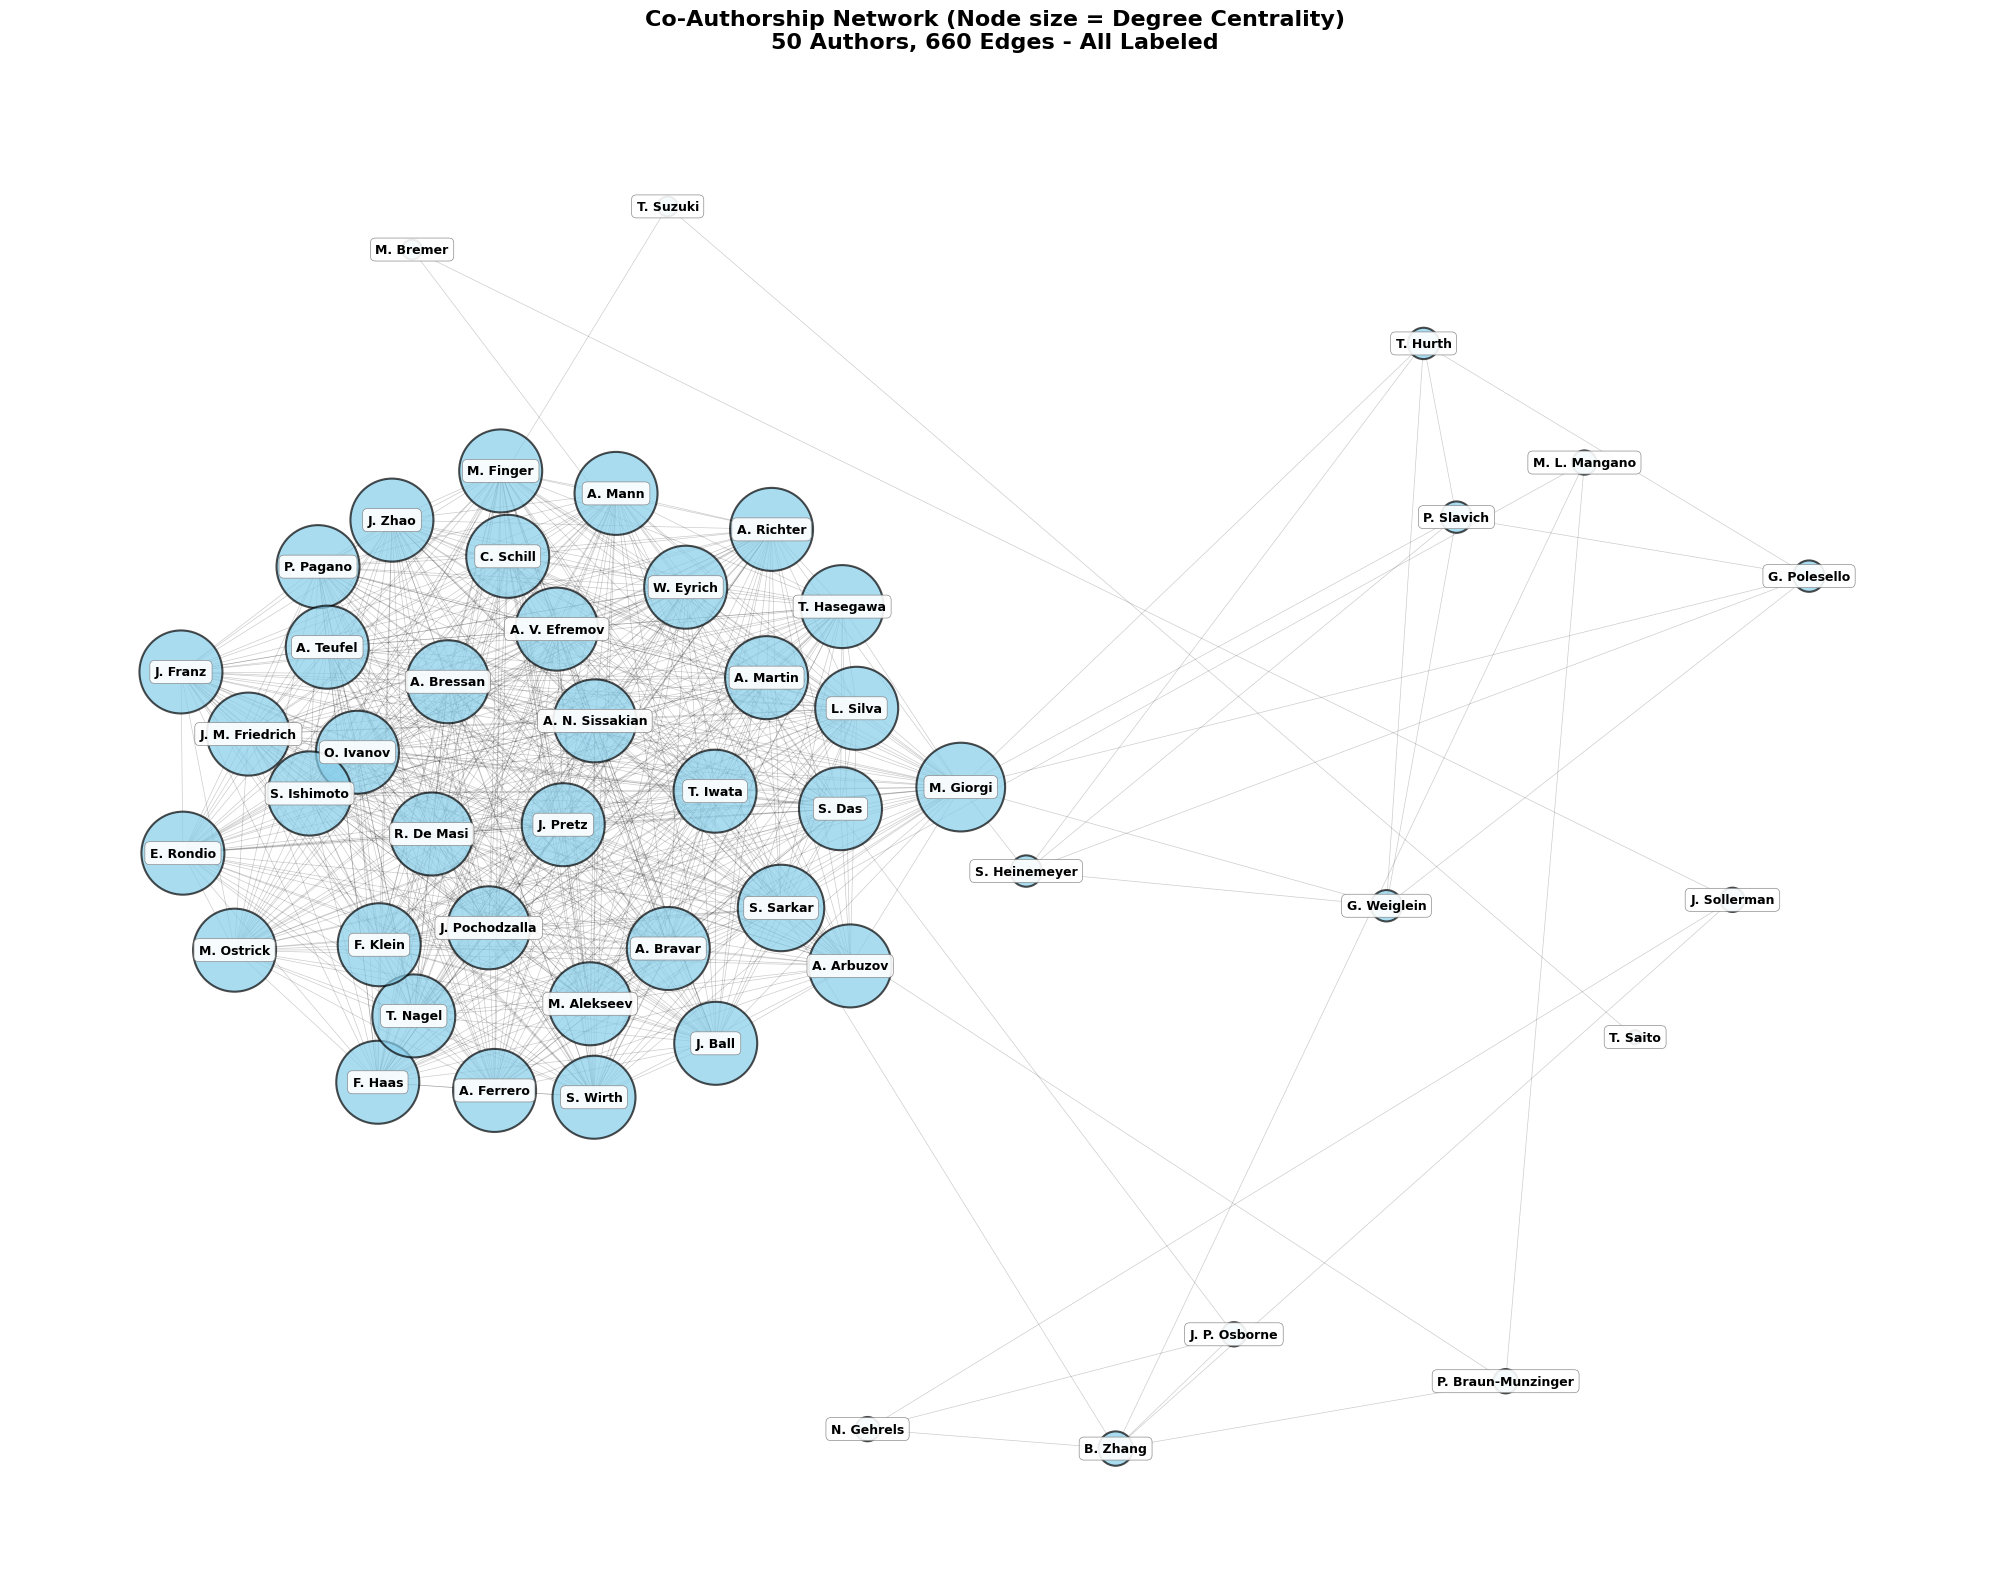

In [19]:
# 6. Visualization: node size = degree centrality
plt.figure(figsize=(20, 16))

# Use all nodes in the trimmed network (~50 nodes)
# Increase k to spread nodes further apart
pos = nx.spring_layout(G, seed=42, k=1.5, iterations=50)
nx.draw_networkx_nodes(G, pos, node_size=[degree_centrality[n]*5000 for n in G.nodes()], alpha=0.7, node_color='skyblue', edgecolors='black', linewidths=1.5)
nx.draw_networkx_edges(G, pos, alpha=0.2, width=0.5)

# Label ALL nodes with white background
labels = {node: node for node in G.nodes()}
nx.draw_networkx_labels(G, pos, labels=labels, font_size=9, font_weight='bold', font_color='black', 
                        bbox=dict(boxstyle='round,pad=0.4', facecolor='white', edgecolor='gray', alpha=0.9, linewidth=0.5))

plt.title(f'Co-Authorship Network (Node size = Degree Centrality)\n{G.number_of_nodes()} Authors, {G.number_of_edges()} Edges - All Labeled', fontsize=16, fontweight='bold', pad=20)
plt.axis('off')
plt.tight_layout()
plt.show()


In [20]:
# 7. Summary Tables for report inclusion
summary_tables = {
    'Degree Centrality': top_degree,
    'Betweenness Centrality': top_betweenness,
    'Closeness Centrality': top_closeness
}

for name, table in summary_tables.items():
    print(f"\n===== {name} =====")
    print(table.to_string(index=False))



===== Degree Centrality =====
        Author   Degree  Betweenness  Closeness
     M. Giorgi 0.816327     0.187075   0.765625
     S. Sarkar 0.775510     0.250000   0.790323
   S. Ishimoto 0.734694     0.079932   0.731343
     M. Finger 0.714286     0.000000   0.710145
     A. Martin 0.714286     0.000000   0.710145
       F. Haas 0.714286     0.000000   0.710145
      J. Franz 0.714286     0.000000   0.710145
    A. Arbuzov 0.714286     0.000000   0.710145
      J. Pretz 0.714286     0.000000   0.710145
J. Pochodzalla 0.714286     0.000000   0.710145

===== Betweenness Centrality =====
       Author   Degree  Betweenness  Closeness
    S. Sarkar 0.775510     0.250000   0.790323
    M. Giorgi 0.816327     0.187075   0.765625
     B. Zhang 0.122449     0.153345   0.490000
  S. Ishimoto 0.734694     0.079932   0.731343
    T. Suzuki 0.040816     0.040816   0.433628
J. P. Osborne 0.061224     0.019983   0.337931
 J. Sollerman 0.061224     0.019983   0.337931
   N. Gehrels 0.061224     0.

## Interpretation: Network Leaders and Connectors

### Understanding the Centrality Metrics:

**Degree Centrality (The "Popular" Authors)**
- Measures: Direct connections (number of collaborators)
- High degree = authors who collaborate with many others
- These are the **"hubs"** or **"leaders"** who work extensively with many researchers

**Betweenness Centrality (The "Bridge" Authors)**
- Measures: How often an author lies on shortest paths between other authors
- High betweenness = authors who connect different research groups
- These are the **"bridges"** or **"connectors"** who link disparate communities

**Closeness Centrality (The "Central" Authors)**
- Measures: Average distance to all other authors in the network
- High closeness = authors who can reach everyone quickly
- These are the **"central figures"** who are well-positioned in the network

### Key Insights:
- Authors appearing in **all three** top-10 lists are the most influential overall
- **Degree leaders** = prolific collaborators (high visibility)
- **Betweenness leaders** = key intermediaries (information brokers)
- **Closeness leaders** = centrally positioned (strategic influence)

In [21]:
# 8. Identify Overall Influential Authors (appearing in multiple top-10 lists)

# Get sets of top authors for each metric
top_degree_authors = set(top_degree['Author'].tolist())
top_betweenness_authors = set(top_betweenness['Author'].tolist())
top_closeness_authors = set(top_closeness['Author'].tolist())

# Find authors appearing in all three lists (most influential overall)
all_three = top_degree_authors & top_betweenness_authors & top_closeness_authors
in_two = ((top_degree_authors & top_betweenness_authors) | 
          (top_degree_authors & top_closeness_authors) | 
          (top_betweenness_authors & top_closeness_authors)) - all_three

print("=" * 80)
print("NETWORK INFLUENCE ANALYSIS")
print("=" * 80)

print(f"\nOVERALL LEADERS (Top in ALL 3 metrics): {len(all_three)} authors")
if all_three:
    for author in sorted(all_three):
        deg = centrality_df[centrality_df['Author'] == author]['Degree'].values[0]
        bet = centrality_df[centrality_df['Author'] == author]['Betweenness'].values[0]
        clo = centrality_df[centrality_df['Author'] == author]['Closeness'].values[0]
        print(f"   • {author}")
        print(f"     Degree: {deg:.4f} | Betweenness: {bet:.4f} | Closeness: {clo:.4f}")
else:
    print("   None (no author ranks in top 10 for all three metrics)")

print(f"\nSIGNIFICANT INFLUENCERS (Top in 2 metrics): {len(in_two)} authors")
for author in sorted(in_two):
    metrics = []
    if author in top_degree_authors: metrics.append("Degree")
    if author in top_betweenness_authors: metrics.append("Betweenness")
    if author in top_closeness_authors: metrics.append("Closeness")
    print(f"   • {author} ({', '.join(metrics)})")

print("\n" + "=" * 80)
print("ROLE IDENTIFICATION:")
print("=" * 80)
print(f"\nHUBS/LEADERS (High Degree only):")
hubs_only = top_degree_authors - top_betweenness_authors - top_closeness_authors
for author in sorted(list(hubs_only)[:5]):
    print(f"   • {author} - Prolific collaborator with many direct connections")

print(f"\nBRIDGES/CONNECTORS (High Betweenness only):")
bridges_only = top_betweenness_authors - top_degree_authors - top_closeness_authors
for author in sorted(list(bridges_only)[:5]):
    print(f"   • {author} - Key intermediary connecting different research groups")

print(f"\nCENTRAL FIGURES (High Closeness only):")
central_only = top_closeness_authors - top_degree_authors - top_betweenness_authors
for author in sorted(list(central_only)[:5]):
    print(f"   • {author} - Well-positioned to access the entire network")

print("\n" + "=" * 80)


NETWORK INFLUENCE ANALYSIS

OVERALL LEADERS (Top in ALL 3 metrics): 4 authors
   • M. Finger
     Degree: 0.7143 | Betweenness: 0.0000 | Closeness: 0.7101
   • M. Giorgi
     Degree: 0.8163 | Betweenness: 0.1871 | Closeness: 0.7656
   • S. Ishimoto
     Degree: 0.7347 | Betweenness: 0.0799 | Closeness: 0.7313
   • S. Sarkar
     Degree: 0.7755 | Betweenness: 0.2500 | Closeness: 0.7903

SIGNIFICANT INFLUENCERS (Top in 2 metrics): 6 authors
   • A. Arbuzov (Degree, Closeness)
   • A. Martin (Degree, Closeness)
   • F. Haas (Degree, Closeness)
   • J. Franz (Degree, Closeness)
   • J. Pochodzalla (Degree, Closeness)
   • J. Pretz (Degree, Closeness)

ROLE IDENTIFICATION:

HUBS/LEADERS (High Degree only):

BRIDGES/CONNECTORS (High Betweenness only):
   • B. Zhang - Key intermediary connecting different research groups
   • J. P. Osborne - Key intermediary connecting different research groups
   • J. Sollerman - Key intermediary connecting different research groups
   • M. Bremer - Key inte